**Pascal VOC 2012の画像データからU-Netモデルで画像生成(Image to Image)する**

In [ ]:
# オリジナル画像からRGBのセグメント画像(3チャンネルのセグメント画像)を生成する
# 学習では、セグメント画像をPからRGBにして、それを正解データにする
# 画像領域分類タスクを画像生成タスクっぽくしてみる

In [ ]:
from datetime import datetime
import glob
import IPython
import os
import pickle
import PIL
import pprint
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchvision
import tqdm
random.seed(3407)
np.random.seed(3407)
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)
torch.backends.cudnn.benchmark = True  # ループ内で順伝播や逆伝播が同じ計算手法ならば処理を高速化させる

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Pascal VOC 2012データをダウンロード
torchvision.datasets.VOCDetection(root="./data",  # データが有る場合は参照先、無い場合はダウンロード先
                                  year="2012",  # 取得するPascal VOCデータセットの年度
                                  image_set="val",  # 取得するPascal VOCデータセットの種別  # trainやtrainvalだとデータ数が多いのでvalのみにする
                                  download=True,  # 引数rootのディレクトリにデータが無い場合にダウンロードするかどうか
                                  transform=None,  # 取得時に画像データへ行う処理
                                  target_transform=None)  # 取得時にラベルデータへ行う処理

In [ ]:
# Pascal VOC 2012データのvalのオリジナル画像とセグメント画像(RGB化)で教師データを準備
original_image_file_list = glob.glob("./data/VOCdevkit/VOC2012/JPEGImages/*.jpg")  # オリジナル画像のパスを全て取得
segment_image_file_list = glob.glob("./data/VOCdevkit/VOC2012/SegmentationClass/*.png")  # セグメント画像のパスを全て取得
original_image_RGB_PIL_list = []
segment_image_RGB_PIL_list = []
original_num_data = len(original_image_file_list)
segment_num_data = len(segment_image_file_list)
for i in range(segment_num_data):
    segment_image_file_name = segment_image_file_list[i][-15:-4]  # 1つ毎にセグメント画像のファイル名の番号部分を取得
    for j in range(original_num_data):
        original_image_file_name = original_image_file_list[j][-15:-4]  # 1つ毎にオリジナル画像のファイル名の番号部分を取得
        if original_image_file_name == segment_image_file_name:  # ファイル名の番号部分がオリジナル画像とセグメント画像で同じならば
            original_image_RGB_PIL = PIL.Image.open(original_image_file_list[j])  # 対象のオリジナル画像をPILへ変換
            segment_image_PIL = PIL.Image.open(segment_image_file_list[i])  # 対象のセグメント画像をPILへ変換
            segment_image_RGB_PIL = segment_image_PIL.convert(mode="RGB")  # セグメント画像のインデックスカラーをRGB(ダイレクトカラー)へ変換
            if len(np.array(original_image_RGB_PIL).shape) == 3:  # 画像が3階数テンソルならば
                original_image_RGB_PIL_list.append(original_image_RGB_PIL)  # PILのオリジナル画像をリストに保管(後続のDataset処理に向けて)
            if len(np.array(segment_image_RGB_PIL).shape) == 3:  # 画像が3階数テンソルならば
                segment_image_RGB_PIL_list.append(segment_image_RGB_PIL)  # PILでRGBにしたセグメント画像をリストに保管(後続のDataset処理に向けて)
        else:
            continue
print(len(original_image_RGB_PIL_list))
print(original_image_RGB_PIL_list[0])
print(np.array(original_image_RGB_PIL_list[0]).shape)
print("オリジナル画像")
IPython.display.display(original_image_RGB_PIL_list[0])
print(len(segment_image_RGB_PIL_list))
print(segment_image_RGB_PIL_list[0])
print(np.array(segment_image_RGB_PIL_list[0]).shape)
print("RGBにしたセグメント画像")
IPython.display.display(segment_image_RGB_PIL_list[0])

In [ ]:
# 教師データの80%をtrainデータ、20%をvalidationデータ
num_data = len(original_image_RGB_PIL_list)
train_original_image_RGB_PIL = original_image_RGB_PIL_list[:int(num_data*0.8)]
valid_original_image_RGB_PIL = original_image_RGB_PIL_list[int(num_data*0.8):]
train_segment_image_RGB_PIL = segment_image_RGB_PIL_list[:int(num_data*0.8)]
valid_segment_image_RGB_PIL = segment_image_RGB_PIL_list[int(num_data*0.8):]
print(len(train_original_image_RGB_PIL))
print(len(valid_original_image_RGB_PIL))

**前処理の準備**

In [ ]:
# データ拡張(Data Augmentation)を定義
image_transform_method = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(224, 224))])

In [ ]:
# 正規化とテンソル化を定義
def normalize_and_tensorize(PIL_image):
    numpy_image = np.array(PIL_image)
    numpy_image_for_torch = numpy_image.transpose(2, 0, 1)
    normalized_numpy_image = numpy_image_for_torch / 255
    normalized_tensor_image = torch.FloatTensor(normalized_numpy_image)
    return normalized_tensor_image

In [ ]:
# Datasetクラスを定義
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, input_PIL_image_list, answer_PIL_image_list, data_augmentation, tensorize):
        super().__init__()
        self.input_PIL_image_list = input_PIL_image_list
        self.answer_PIL_image_list = answer_PIL_image_list
        self.data_augmentation = data_augmentation
        self.tensorize = tensorize

    def __len__(self):
        return len(self.input_PIL_image_list)

    def __getitem__(self, idx):
        input_PIL_image = self.input_PIL_image_list[idx]
        augmentation_input_PIL_image = self.data_augmentation(input_PIL_image)
        input_tensor = self.tensorize(augmentation_input_PIL_image)
        answer_PIL_image = self.answer_PIL_image_list[idx]
        augmentation_answer_PIL_image = self.data_augmentation(answer_PIL_image)
        answer_tensor = self.tensorize(augmentation_answer_PIL_image)
        return input_tensor, answer_tensor

**前処理**

In [ ]:
train_dataset = MyDataset(input_PIL_image_list=train_original_image_RGB_PIL,
                          answer_PIL_image_list=train_segment_image_RGB_PIL,
                          data_augmentation=image_transform_method,
                          tensorize=normalize_and_tensorize)
valid_dataset = MyDataset(input_PIL_image_list=valid_original_image_RGB_PIL,
                          answer_PIL_image_list=valid_segment_image_RGB_PIL,
                          data_augmentation=image_transform_method,
                          tensorize=normalize_and_tensorize)

In [ ]:
train_dataset_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                       batch_size=20,
                                                       shuffle=None)
valid_dataset_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                       batch_size=20,
                                                       shuffle=None)

**U-Netモデルを作成**

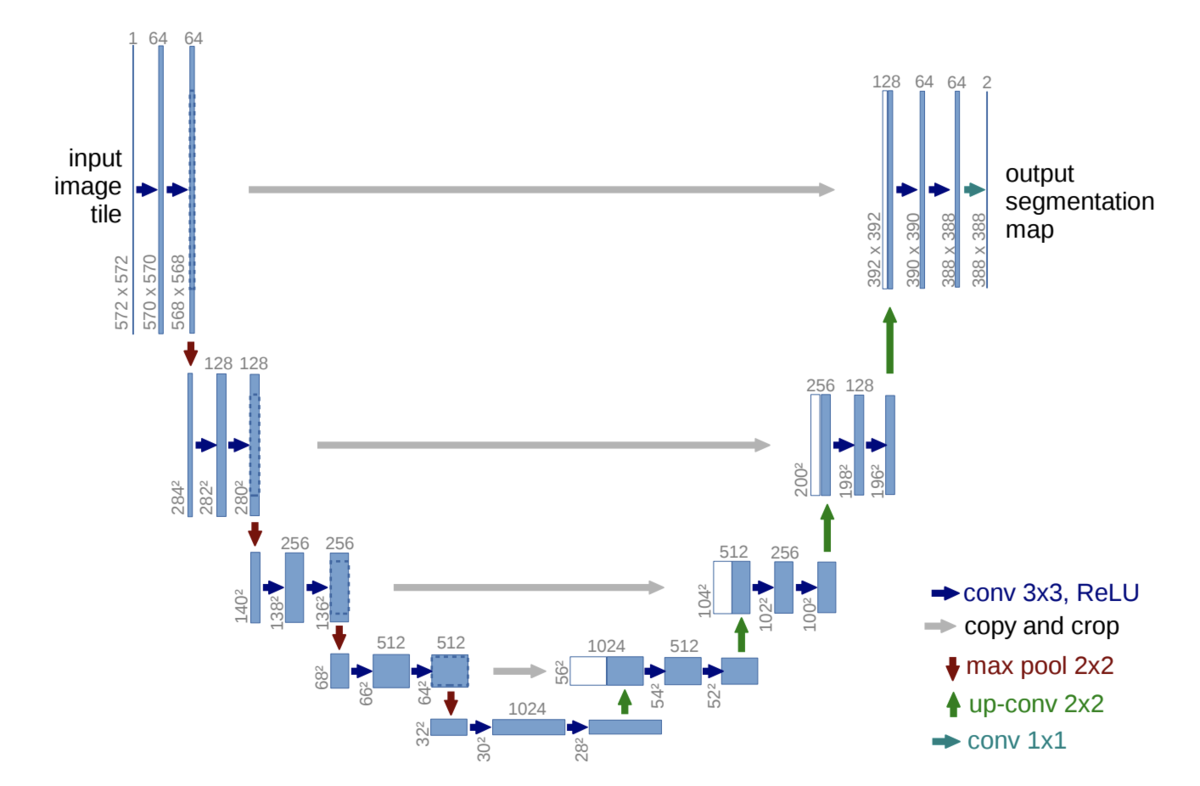

In [ ]:
class MyUNetConvBlock(torch.nn.Module):
    def __init__(self, in_num_block, out_num_block):
        super().__init__()
        self.layer_1 = torch.nn.Conv2d(in_channels=in_num_block, out_channels=out_num_block, kernel_size=3, stride=1, padding=1)  # 解像度はそのままで畳み込み
        self.layer_2 = torch.nn.BatchNorm2d(num_features=out_num_block)
        self.layer_3 = torch.nn.ReLU()

    def forward(self, in_data_block):
        out_data_layer_1 = self.layer_1(in_data_block)
        out_data_layer_2 = self.layer_2(out_data_layer_1)
        out_data_layer_3 = self.layer_3(out_data_layer_2)
        return out_data_layer_3

In [ ]:
class MyUNetConvLayer(torch.nn.Module):
    def __init__(self, in_num_layer, out_num_layer):
        super().__init__()
        self.layer_1 = MyUNetConvBlock(in_num_block=in_num_layer, out_num_block=out_num_layer)  # チャンネルを出力チャンネル数にして畳み込み
        self.layer_2 = MyUNetConvBlock(in_num_block=out_num_layer, out_num_block=out_num_layer)  # チャンネルをそのままで畳み込み
        self.layer_3 = MyUNetConvBlock(in_num_block=out_num_layer, out_num_block=out_num_layer)  # チャンネルをそのままで畳み込み

    def forward(self, in_data_layer):
        out_data_layer_1 = self.layer_1(in_data_block=in_data_layer)
        # print("a", out_data_layer_1.shape)
        out_data_layer_2 = self.layer_2(in_data_block=out_data_layer_1)
        # print("b", out_data_layer_2.shape)
        out_data_layer_3 = self.layer_3(in_data_block=out_data_layer_2)
        # print("c", out_data_layer_3.shape)
        return out_data_layer_3

In [ ]:
class MyUNetUpConvBlock(torch.nn.Module):
    def __init__(self, in_num_block, out_num_block):
        super().__init__()
        self.layer_1 = torch.nn.ConvTranspose2d(in_channels=in_num_block, out_channels=out_num_block, kernel_size=3, stride=2, padding=1, output_padding=1)  # 解像度を2倍にして畳み込み
        self.layer_2 = torch.nn.BatchNorm2d(num_features=out_num_block)
        self.layer_3 = torch.nn.ReLU()

    def forward(self, in_data_block):
        out_data_layer_1 = self.layer_1(in_data_block)
        out_data_layer_2 = self.layer_2(out_data_layer_1)
        out_data_layer_3 = self.layer_3(out_data_layer_2)
        return out_data_layer_3

In [ ]:
class MyUNet(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layer_1_encoder = MyUNetConvLayer(in_num_layer=in_dim, out_num_layer=64)  # 畳み込み層(入力)
        self.layer_1_to_2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # ダウンサンプリング層(解像度を半分)
        self.layer_2_encoder = MyUNetConvLayer(in_num_layer=64, out_num_layer=128)  # 畳み込み層
        self.layer_2_to_3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # ダウンサンプリング層(解像度を半分)
        self.layer_3_encoder = MyUNetConvLayer(in_num_layer=128, out_num_layer=256)  # 畳み込み層
        self.layer_3_to_4 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # ダウンサンプリング層(解像度を半分)
        self.layer_4_encoder = MyUNetConvLayer(in_num_layer=256, out_num_layer=512)  # 畳み込み層
        self.layer_4_to_5 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # ダウンサンプリング層(解像度を半分)
        self.layer_5_bridge = MyUNetConvLayer(in_num_layer=512, out_num_layer=1024)  # 畳み込み層
        self.layer_5_to_6 = MyUNetUpConvBlock(in_num_block=1024, out_num_block=512)  # アップサンプリング層(チャンネルを半分、解像度を2倍)
        self.layer_6_decoder = MyUNetConvLayer(in_num_layer=1024, out_num_layer=512)  # 畳み込み層(入力はskip-connection有り)
        self.layer_6_to_7 = MyUNetUpConvBlock(in_num_block=512, out_num_block=256)  # アップサンプリング層(チャンネルを半分、解像度を2倍)
        self.layer_7_decoder = MyUNetConvLayer(in_num_layer=512, out_num_layer=256)  # 畳み込み層(入力はskip-connection有り)
        self.layer_7_to_8 = MyUNetUpConvBlock(in_num_block=256, out_num_block=128)  # アップサンプリング層(チャンネルを半分、解像度を2倍)
        self.layer_8_decoder = MyUNetConvLayer(in_num_layer=256, out_num_layer=128)  # 畳み込み層(入力はskip-connection有り)
        self.layer_8_to_9 = MyUNetUpConvBlock(in_num_block=128, out_num_block=64)  # アップサンプリング層(チャンネルを半分、解像度を2倍)
        self.layer_9_decoder = MyUNetConvLayer(in_num_layer=128, out_num_layer=64)  # 畳み込み層(入力はskip-connection有り)
        self.layer_10_decoder = torch.nn.Conv2d(in_channels=64, out_channels=out_dim, kernel_size=3, stride=1, padding=1)  # 畳み込み層(出力)

    def forward(self, in_data):
        # print("入力", in_data.shape)  # torch.Size([20, 3, 224, 224])
        out_data_layer_1_encoder = self.layer_1_encoder(in_data)
        # print("1", out_data_layer_1_encoder.shape)  # torch.Size([20, 64, 224, 224])
        out_data_layer_1_to_2 = self.layer_1_to_2(out_data_layer_1_encoder)
        # print("1to2", out_data_layer_1_to_2.shape)  # torch.Size([20, 64, 112, 112])
        out_data_layer_2_encoder = self.layer_2_encoder(out_data_layer_1_to_2)
        # print("2", out_data_layer_2_encoder.shape)  # torch.Size([20, 128, 112, 112])
        out_data_layer_2_to_3 = self.layer_2_to_3(out_data_layer_2_encoder)
        # print("2to3", out_data_layer_2_to_3.shape)  # torch.Size([20, 128, 56, 56])
        out_data_layer_3_encoder = self.layer_3_encoder(out_data_layer_2_to_3)
        # print("3", out_data_layer_3_encoder.shape)  # torch.Size([20, 256, 56, 56])
        out_data_layer_3_to_4 = self.layer_3_to_4(out_data_layer_3_encoder)
        # print("3to4", out_data_layer_3_to_4.shape)  # torch.Size([20, 256, 28, 28])
        out_data_layer_4_encoder = self.layer_4_encoder(out_data_layer_3_to_4)
        # print("4", out_data_layer_4_encoder.shape)  # torch.Size([20, 512, 28, 28])
        out_data_layer_4_to_5 = self.layer_4_to_5(out_data_layer_4_encoder)
        # print("4to5", out_data_layer_4_to_5.shape)  # torch.Size([20, 512, 14, 14])
        out_data_layer_5_bridge = self.layer_5_bridge(out_data_layer_4_to_5)
        # print("5", out_data_layer_5_bridge.shape)  # torch.Size([20, 1024, 14, 14])
        out_data_layer_5_to_6 = self.layer_5_to_6(out_data_layer_5_bridge)
        # print("5to6", out_data_layer_5_to_6.shape)  # torch.Size([20, 512, 28, 28])
        in_data_layer_6_decoder = torch.cat([out_data_layer_5_to_6, out_data_layer_4_encoder], dim=1)
        # print("in6", in_data_layer_6_decoder.shape)  # torch.Size([20, 1024, 28, 28])
        out_data_layer_6_decoder = self.layer_6_decoder(in_data_layer_6_decoder)
        # print("6", out_data_layer_6_decoder.shape)  # torch.Size([20, 512, 28, 28])
        out_data_layer_6_to_7 = self.layer_6_to_7(out_data_layer_6_decoder)
        # print("6to7", out_data_layer_6_to_7.shape)  # torch.Size([20, 256, 56, 56])
        in_data_layer_7_decoder = torch.cat([out_data_layer_6_to_7, out_data_layer_3_encoder], dim=1)
        # print("in7", in_data_layer_7_decoder.shape)  # torch.Size([20, 512, 56, 56])
        out_data_layer_7_decoder = self.layer_7_decoder(in_data_layer_7_decoder)
        # print("7", out_data_layer_7_decoder.shape)  # torch.Size([20, 256, 56, 56])
        out_data_layer_7_to_8 = self.layer_7_to_8(out_data_layer_7_decoder)
        # print("7to8", out_data_layer_7_to_8.shape)  # torch.Size([20, 128, 112, 112])
        in_data_layer_8_decoder = torch.cat([out_data_layer_7_to_8, out_data_layer_2_encoder], dim=1)
        # print("in8", in_data_layer_8_decoder.shape)  # torch.Size([20, 256, 112, 112])
        out_data_layer_8_decoder = self.layer_8_decoder(in_data_layer_8_decoder)
        # print("8", out_data_layer_8_decoder.shape)  # torch.Size([20, 128, 112, 112])
        out_data_layer_8_to_9 = self.layer_8_to_9(out_data_layer_8_decoder)
        # print("8to9", out_data_layer_8_to_9.shape)  # torch.Size([20, 64, 224, 224])
        in_data_layer_9_decoder = torch.cat([out_data_layer_8_to_9, out_data_layer_1_encoder], dim=1)
        # print("in9", in_data_layer_9_decoder.shape)  # torch.Size([20, 128, 224, 224])
        out_data_layer_9_decoder = self.layer_9_decoder(in_data_layer_9_decoder)
        # print("9", out_data_layer_9_decoder.shape)  # torch.Size([20, 64, 224, 224])
        out_data_layer_10_decoder = self.layer_10_decoder(out_data_layer_9_decoder)
        # print("10", out_data_layer_10_decoder.shape)  # torch.Size([20, 3, 224, 224])
        return out_data_layer_10_decoder

**モデル、損失関数、最適化アルゴリズム**

In [ ]:
nn_model = MyUNet(in_dim=3,
                  out_dim=3).to(device)  # GPUへ
loss_f = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(),
                             lr=0.001)

In [ ]:
torchinfo.summary(nn_model,
                  input_size=(20, 3, 224, 224),
                  depth=5)

Layer (type:depth-idx)                   Output Shape              Param #
MyUNet                                   [20, 3, 224, 224]         --
├─MyUNetConvLayer: 1-1                   [20, 64, 224, 224]        --
│    └─MyUNetConvBlock: 2-1              [20, 64, 224, 224]        --
│    │    └─Conv2d: 3-1                  [20, 64, 224, 224]        1,792
│    │    └─BatchNorm2d: 3-2             [20, 64, 224, 224]        128
│    │    └─ReLU: 3-3                    [20, 64, 224, 224]        --
│    └─MyUNetConvBlock: 2-2              [20, 64, 224, 224]        --
│    │    └─Conv2d: 3-4                  [20, 64, 224, 224]        36,928
│    │    └─BatchNorm2d: 3-5             [20, 64, 224, 224]        128
│    │    └─ReLU: 3-6                    [20, 64, 224, 224]        --
│    └─MyUNetConvBlock: 2-3              [20, 64, 224, 224]        --
│    │    └─Conv2d: 3-7                  [20, 64, 224, 224]        36,928
│    │    └─BatchNorm2d: 3-8             [20, 64, 224, 224]        128
│

**学習と検証**

In [ ]:
if os.path.isfile("./epoch_train_loss_total_list.pkl"):
    with open("./epoch_train_loss_total_list.pkl", mode="rb") as f:
        epoch_train_loss_total_list = pickle.load(f)
else:
    epoch_train_loss_total_list = []
if os.path.isfile("./epoch_valid_loss_total_list.pkl"):
    with open("./epoch_valid_loss_total_list.pkl", mode="rb") as f:
        epoch_valid_loss_total_list = pickle.load(f)
else:
    epoch_valid_loss_total_list = []
if os.path.isfile("./FineTuning_U-Net.model"):
    nn_model.load_state_dict(torch.load("./FineTuning_U-Net.model"))
# エポック毎に学習と検証
for epoch in tqdm.notebook.tqdm(range(10)):
    # 学習
    epoch_train_loss_total = 0
    nn_model.train()
    for train_input_tensor_minibatch, train_answer_tensor_minibatch in train_dataset_dataloader:
        print("train_input", train_input_tensor_minibatch.shape)
        print("train_answer", train_answer_tensor_minibatch.shape)
        train_input_tensor_minibatch = train_input_tensor_minibatch.to(device)  # GPUへ
        train_answer_tensor_minibatch = train_answer_tensor_minibatch.to(device)  # GPUへ
        output = nn_model(in_data=train_input_tensor_minibatch)
        print("output", output.shape)
        loss = loss_f(output, train_answer_tensor_minibatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss_total = epoch_train_loss_total + loss.item()
    epoch_train_loss_total_list.append(epoch_train_loss_total)
    with open("./epoch_train_loss_total_list.pkl", mode="wb") as f:
        pickle.dump(obj=epoch_train_loss_total_list, file=f)
    torch.save(nn_model.state_dict(), "./FineTuning_U-Net.model")
    # 検証
    epoch_valid_loss_total = 0
    nn_model.eval()
    with torch.no_grad():
        for valid_input_tensor_minibatch, valid_answer_tensor_minibatch in valid_dataset_dataloader:
            print("valid_input", valid_input_tensor_minibatch.shape)
            print("valid_answer", valid_answer_tensor_minibatch.shape)
            valid_input_tensor_minibatch = valid_input_tensor_minibatch.to(device)  # GPUへ
            valid_answer_tensor_minibatch = valid_answer_tensor_minibatch.to(device)  # GPUへ
            predict = nn_model(in_data=valid_input_tensor_minibatch)
            print("predict", predict.shape)
            loss = loss_f(predict, valid_answer_tensor_minibatch)
            epoch_valid_loss_total = epoch_valid_loss_total + loss.item()
        epoch_valid_loss_total_list.append(epoch_valid_loss_total)
        with open("./epoch_valid_loss_total_list.pkl", mode="wb") as f:
            pickle.dump(obj=epoch_valid_loss_total_list, file=f)

In [ ]:
with open("./epoch_train_loss_total_list.pkl", mode="rb") as f:
    epoch_train_loss_total_list = pickle.load(file=f)
with open("./epoch_valid_loss_total_list.pkl", mode="rb") as f:
    epoch_valid_loss_total_list = pickle.load(file=f)

In [ ]:
x_datas = np.arange(1, len(epoch_train_loss_total_list)+1, 1)
y_datas_list = [epoch_train_loss_total_list, epoch_valid_loss_total_list]
labels = ["train", "valid"]
colors = list(matplotlib.colors.CSS4_COLORS.values())
random.shuffle(colors)
label2color = colors[:len(labels)]

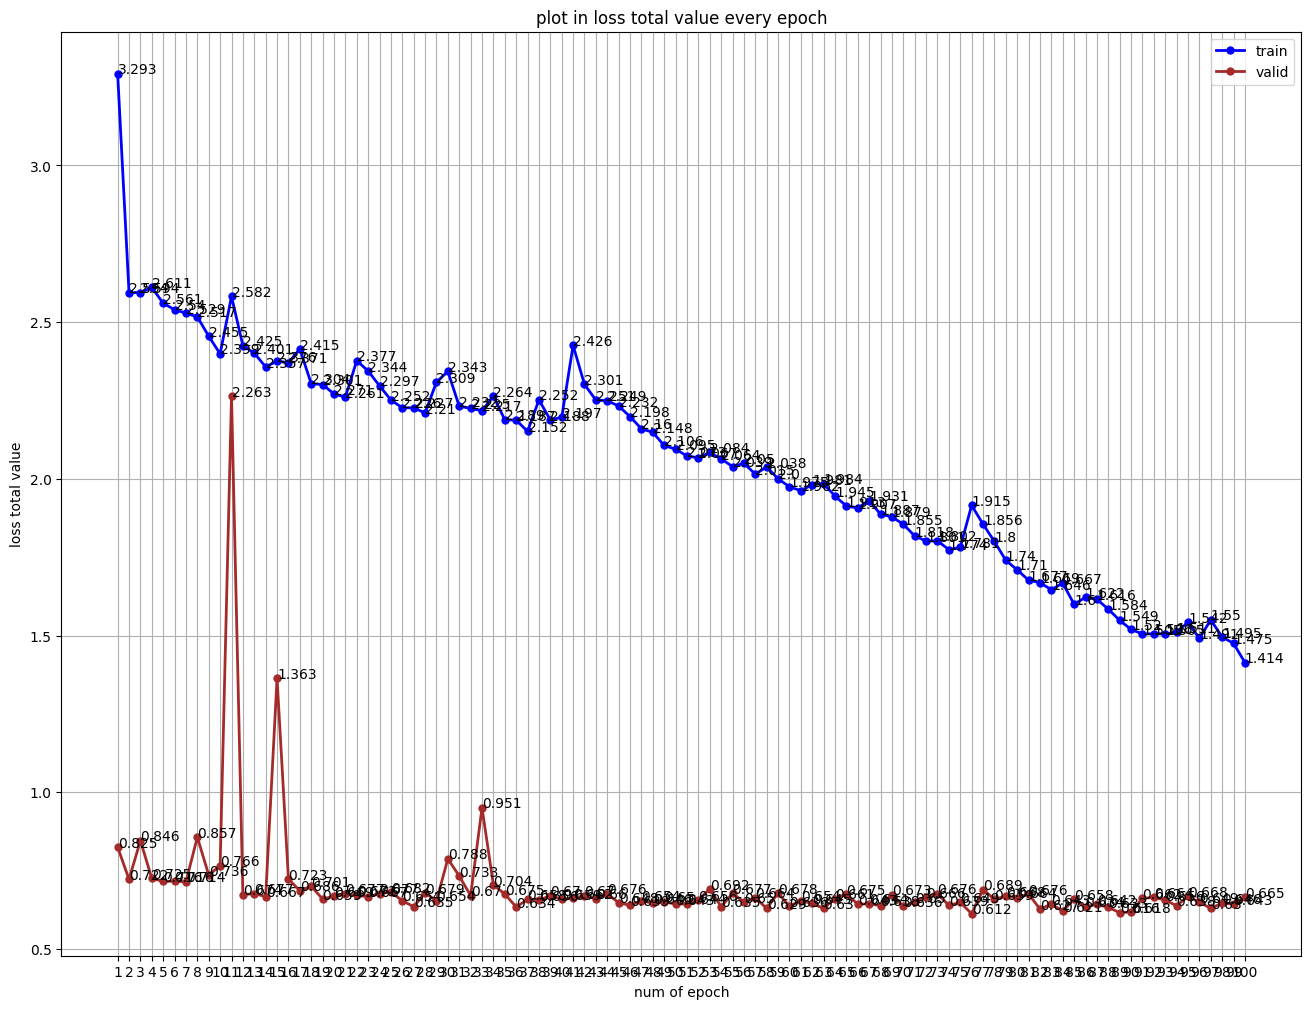

In [ ]:
fig, (axes1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))
for i, y_datas in enumerate(y_datas_list):
    axes1.plot(x_datas, y_datas, label=labels[i], c=label2color[i], marker="o", markersize=5, linestyle="solid", linewidth=2)
    for j in range(len(y_datas)):
        axes1.annotate(text=round(y_datas[j], 3), xy=(x_datas[j], y_datas[j]))
axes1.legend()
axes1.set_title("plot in loss total value every epoch")
axes1.set_xlabel("num of epoch")
axes1.set_ylabel("loss total value")
axes1.set_xticks(ticks=x_datas)
axes1.grid(True)
plt.show()

**検証**

In [ ]:
def denormalize_and_numpize(tensor_image_data):
    numpy_image_data = tensor_image_data.detach().cpu().numpy()
    numpy_image_data_for_PIL_shape = numpy_image_data.transpose(0, 2, 3, 1)
    denormalize_numpy_image_data_for_PIL_shape = numpy_image_data_for_PIL_shape * 255
    denormalize_numpy_image_data_for_PIL_shape_dtype = denormalize_numpy_image_data_for_PIL_shape.astype(dtype=np.uint8)
    return denormalize_numpy_image_data_for_PIL_shape_dtype

In [ ]:
nn_model.eval()
with torch.no_grad():
    if os.path.isfile("./FineTuning_U-Net.model"):
        nn_model.load_state_dict(torch.load("./FineTuning_U-Net.model"))
    predict_numpy_list = []
    valid_input_numpy_list = []
    valid_answer_numpy_list = []
    for valid_input_tensor_minibatch, valid_answer_tensor_minibatch in tqdm.notebook.tqdm(valid_dataset_dataloader):
        valid_input_tensor_minibatch = valid_input_tensor_minibatch.to(device)  # GPUへ
        valid_answer_tensor_minibatch = valid_answer_tensor_minibatch.to(device)  # GPUへ
        predict = nn_model(in_data=valid_input_tensor_minibatch)
        predict_numpy_for_PIL = denormalize_and_numpize(tensor_image_data=predict)
        predict_numpy_list.append(predict_numpy_for_PIL)
        valid_input_numpy_for_PIL = denormalize_and_numpize(tensor_image_data=valid_input_tensor_minibatch)
        valid_input_numpy_list.append(valid_input_numpy_for_PIL)
        valid_answer_numpy_for_PIL = denormalize_and_numpize(tensor_image_data=valid_answer_tensor_minibatch)
        valid_answer_numpy_list.append(valid_answer_numpy_for_PIL)
    predict_numpy_all = np.concatenate(predict_numpy_list, axis=0)
    print("predict_numpy_all", predict_numpy_all.shape)
    valid_input_numpy_all = np.concatenate(valid_input_numpy_list, axis=0)
    print("valid_input_numpy_all", valid_input_numpy_all.shape)
    valid_answer_numpy_all = np.concatenate(valid_answer_numpy_list, axis=0)
    print("valid_answer_numpy_all", valid_answer_numpy_all.shape)

  0%|          | 0/11 [00:00<?, ?it/s]

predict_numpy_all (211, 224, 224, 3)
valid_input_numpy_all (211, 224, 224, 3)
valid_answer_numpy_all (211, 224, 224, 3)


In [ ]:
valid_input_PIL = PIL.Image.fromarray(valid_input_numpy_all[0], mode="RGB")
IPython.display.display(valid_input_PIL)

In [ ]:
valid_answer_PIL = PIL.Image.fromarray(valid_answer_numpy_all[0], mode="RGB")
IPython.display.display(valid_answer_PIL)

100epoch学習後の推測結果

In [ ]:
predict_PIL = PIL.Image.fromarray(predict_numpy_all[0], mode="RGB")
IPython.display.display(predict_PIL)

90epoch学習後の推測結果

In [ ]:
predict_PIL = PIL.Image.fromarray(predict_numpy_all[0], mode="RGB")
IPython.display.display(predict_PIL)

80epoch学習後の推測結果

In [ ]:
predict_PIL = PIL.Image.fromarray(predict_numpy_all[0], mode="RGB")
IPython.display.display(predict_PIL)

70epoch学習後の推測結果

In [ ]:
predict_PIL = PIL.Image.fromarray(predict_numpy_all[0], mode="RGB")
IPython.display.display(predict_PIL)

60epoch学習後の推測結果

In [ ]:
predict_PIL = PIL.Image.fromarray(predict_numpy_all[0], mode="RGB")
IPython.display.display(predict_PIL)

50epoch学習後の推測結果

In [ ]:
predict_PIL = PIL.Image.fromarray(predict_numpy_all[0], mode="RGB")
IPython.display.display(predict_PIL)

40epoch学習後の推測結果

In [ ]:
predict_PIL = PIL.Image.fromarray(predict_numpy_all[0], mode="RGB")
IPython.display.display(predict_PIL)

30epoch学習後の推測結果

In [ ]:
predict_PIL = PIL.Image.fromarray(predict_numpy_all[0], mode="RGB")
IPython.display.display(predict_PIL)

20epoch学習後の推測結果

In [ ]:
predict_PIL = PIL.Image.fromarray(predict_numpy_all[0], mode="RGB")
IPython.display.display(predict_PIL)

10epoch学習後の推測結果

In [ ]:
predict_PIL = PIL.Image.fromarray(predict_numpy_all[0], mode="RGB")
IPython.display.display(predict_PIL)